In [ ]:
import tensorflow as tf

- We can leverage an existing neural network architecture proven to work on problems similar to our own

- Can leverage a working network architecture which has already learned patterns on similar data to our own

## What we're going to cover:

- introduce transfer learning with TensorFlow,
- Using a small dataset to experiment faster
- Building a transfer learning feature extraction model with TensorFlow Hub
- Use TensorBoard to track modelling experiments and results

In [ ]:
import os
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-30 09:35:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   330MB/s    in 0.5s    

2022-10-30 09:35:20 (330 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:

for dirpaths, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} image in '{dirpaths}'")

There are 2 directories and 0 image in '10_food_classes_10_percent'
There are 10 directories and 0 image in '10_food_classes_10_percent/train'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 image in '10_food_classes_10_percent/train/steak'
There are

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_shape = (224,224)
Batch_size = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=Image_shape,
                                               batch_size=Batch_size,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir, 
                                               target_size=Image_shape,
                                               batch_size=Batch_size,
                                               class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains or after)

- Tracking experiments with the Tensorboard callback,
- Model checkpoint with the ModelCheckpoint callback
- Stopping a model from training (overfitting) with the EarlyStopping callback


In [ ]:
## Create a tensorflow callback 
import datetime

def create_tensorflow_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-&H&M%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensroBoard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False,
                                           input_shape=Image_shape+(3,))
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(10,activation="softmax")
  ])

  return model
  

In [ ]:
model_resnet = create_model(resnet_url)
model_enet = create_model(efficientnet_url)

In [ ]:
model_resnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Compile 
model_resnet.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
his_resnet = model_resnet.fit(train_data,
                steps_per_epoch = len(train_data),
                validation_data=test_data,
                validation_steps = len(test_data),
                epochs=5,
                callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                       experiment_name="resnet50V2",
                                                       )])

Saving TensroBoard log files to: tensorflow_hub/resnet50V2/20221030-&H&M1667122535
Epoch 1/5
24/24 [==============================] - 20s 724ms/step - loss: 1.9763 - accuracy: 0.3573 - val_loss: 1.1786 - val_accuracy: 0.6248
Epoch 2/5
24/24 [==============================] - 17s 728ms/step - loss: 0.9149 - accuracy: 0.7333 - val_loss: 0.8397 - val_accuracy: 0.7396
Epoch 3/5
24/24 [==============================] - 16s 700ms/step - loss: 0.6368 - accuracy: 0.8227 - val_loss: 0.7320 - val_accuracy: 0.7648
Epoch 4/5
24/24 [==============================] - 17s 716ms/step - loss: 0.4862 - accuracy: 0.8693 - val_loss: 0.6971 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 16s 702ms/step - loss: 0.3932 - accuracy: 0.9053 - val_loss: 0.6645 - val_accuracy: 0.7828


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(his):
  loss = his.history["loss"]
  val_loss = his.history["val_loss"]


  accuracy = his.history["accuracy"]
  val_accuracy = his.history["val_accuracy"]

  epochs = range(len(his.history["loss"]))

  ## Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()


  ## Plot accuracy
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()

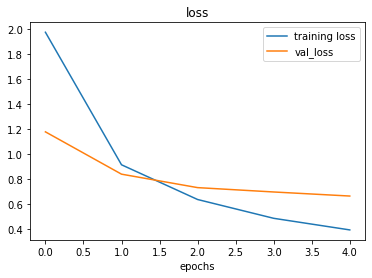

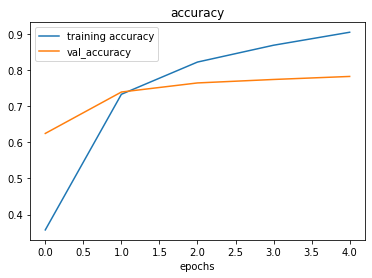

In [ ]:
plot_loss_curves(his_resnet)

In [ ]:
## EfficientNet
efficient_model = create_model(model_url=efficientnet_url)

## Compile
efficient_model.compile(loss="categorical_crossentropy",
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

eff_history = efficient_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=train_data,
                                  validation_steps=len(train_data),
                                  callbacks=[create_tensorflow_callback(dir_name="tensorflow_hub",
                                                       experiment_name="efficientnetb0",
                                                       )])

Saving TensroBoard log files to: tensorflow_hub/efficientnetb0/20221030-&H&M1667122636
Epoch 1/5
24/24 [==============================] - 16s 346ms/step - loss: 1.8133 - accuracy: 0.4600 - val_loss: 1.2791 - val_accuracy: 0.7427
Epoch 2/5
24/24 [==============================] - 7s 306ms/step - loss: 1.0444 - accuracy: 0.7760 - val_loss: 0.8290 - val_accuracy: 0.8253
Epoch 3/5
24/24 [==============================] - 7s 302ms/step - loss: 0.7467 - accuracy: 0.8427 - val_loss: 0.6408 - val_accuracy: 0.8693
Epoch 4/5
24/24 [==============================] - 7s 303ms/step - loss: 0.6021 - accuracy: 0.8680 - val_loss: 0.5327 - val_accuracy: 0.8880
Epoch 5/5
24/24 [==============================] - 7s 298ms/step - loss: 0.5110 - accuracy: 0.8880 - val_loss: 0.4569 - val_accuracy: 0.9013


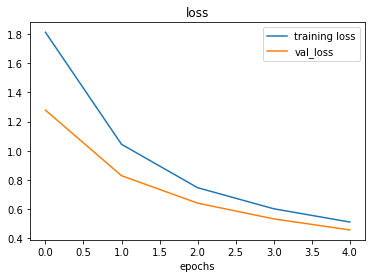

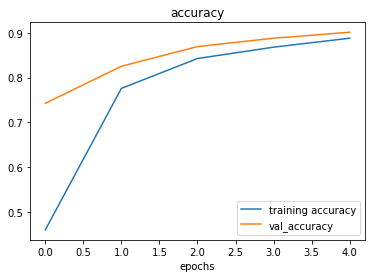

In [ ]:
plot_loss_curves(eff_history)